In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score

# from transformers import BertTokenizer, BertConfig
# from transformers import BertForTokenClassification, AdamW

from transformers import RobertaConfig, RobertaModel
from transformers import RobertaTokenizer, RobertaForTokenClassification, AutoTokenizer, AdamW

from transformers import AutoTokenizer, DistilBertForTokenClassification, AdamW

2023-07-19 10:26:38.265183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 10:26:38.790565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('dataset.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")


In [5]:
def degreekify(char):
    #char will be a character
    greek = {'α': '[alpha]', 'β':'[beta]', 'γ': '[gamma]', 'δ':'[delta]', 'ε': '[epsilon]', 'ζ':'[zeta]', 'η': '[eta]',
            'θ':'[theta]', 'ι': '[iota]', 'κ':'[kappa]', 'λ':'[lambda]', 'μ': '[mu]', 'ν':'[nu]', 'ξ':'[xi]', 'ο':'[omicron]', 'π':'[pi]', 'ρ':'[rho]',
            'σ': '[sigma]', 'τ': '[tau]', 'υ':'[upsilon]', 'φ':'[phi]', 'χ':'[chi]', 'ψ':'[psi]', 'ω':'[omega]' }
    if char in greek:
        return greek[char]
    else:
        return char

In [34]:
def pre_process(text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    text_dict = []
    
    for i in range(len(text)):
        text_dict.append(degreekify(text[i]))
    
    
    
    ann_indices = []
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    
    
    if len(annotations)==0:
        ann_indices.append([[0, len(text)],0])
    else:
        ann_indices.append([[0, annotations[0]['start_offset']], 0])
        for i in range(len(annotations)-1):
            ann_indices.append([[annotations[i]['start_offset'], annotations[i]['end_offset']], annotations[i]['label']])
            ann_indices.append([[annotations[i]['end_offset'], annotations[i+1]['start_offset']], 0])
            
        ann_indices.append([[annotations[-1]['start_offset'], annotations[-1]['end_offset']], annotations[-1]['label']])
        ann_indices.append([[annotations[-1]['end_offset'], len(text)], 0])
         
    
    print(ann_indices)
    labels = []
    sentences = []
    for a in ann_indices:
        
        if a[0][1]-a[0][0] !=0:
            together = ''
            for i in range(a[0][0], a[0][1]):
                together += text_dict[i]
                
            toke = together.split()
            sentences.extend(toke)
            t = len(toke)
            if t != 0:
                temp = [data_tags[2 * a[1]]] * t
                if a[1] != 0:
                    temp[0] = data_tags[2 * a[1]-1]
                labels.extend(temp)
 
    return labels, sentences

In [35]:
#create labels
data_tags = ['0','C', 'C-cont' , 'M', 'M-cont', 'Q', 'Q-cont', 'T' , 'T-cont', 'A' , 'A-cont', 'R', 'R-cont']

sentences, labels = [], []

for i in range(len(info)):
    l,s = pre_process(info[i]['text'], info[i]['annotations'])
    if len(l) != len(s):
        print('fuck')
    else:
        labels.append(l)
        sentences.append(s)

[[[0, 17], 0], [[17, 28], 6], [[28, 89], 0], [[89, 91], 2], [[91, 116], 0], [[116, 131], 1], [[131, 133], 0], [[133, 137], 1], [[137, 247], 0], [[247, 258], 6], [[258, 328], 0], [[328, 332], 1], [[332, 375], 0], [[375, 379], 1], [[379, 461], 0], [[461, 475], 3], [[475, 477], 0], [[477, 481], 1], [[481, 498], 0], [[498, 500], 2], [[500, 540], 0], [[540, 551], 6], [[551, 573], 0], [[573, 580], 3], [[580, 608], 0], [[608, 615], 3], [[615, 659], 0]]
[[[0, 40], 0], [[40, 44], 1], [[44, 91], 0], [[91, 95], 1], [[95, 135], 0], [[135, 142], 1], [[142, 148], 0], [[148, 162], 1], [[162, 216], 0], [[216, 260], 5], [[260, 261], 0], [[261, 269], 3], [[269, 282], 0]]
[[[0, 20], 0], [[20, 24], 1], [[24, 46], 0], [[46, 61], 1], [[61, 100], 0], [[100, 105], 3], [[105, 106], 0], [[106, 110], 5], [[110, 124], 0], [[124, 128], 4], [[128, 129], 0]]
[[[0, 48], 0], [[48, 52], 1], [[52, 110], 0], [[110, 114], 2], [[114, 150], 0], [[150, 159], 3], [[159, 204], 0], [[204, 225], 3], [[225, 259], 0], [[259, 263],

In [37]:
q = 93
l,s = pre_process(info[q]['text'], info[q]['annotations'])

for s, l in zip(sentences[q],labels[q]):
    print(s,l)

print(info[93]['annotations'])
print(135,info[93]['text'][135])

[[[0, 135], 0], [[135, 142], 5], [[142, 374], 0], [[374, 378], 5], [[378, 414], 0], [[414, 419], 5], [[419, 420], 0]]
We 0
determined 0
the 0
single-stage 0
isotope 0
separation 0
factors 0
[alpha] 0
for 0
the 0
four 0
extraction 0
systems. 0
The 0
isotope 0
separation 0
in 0
the 0
systems 0
with 0
H3BO3 A
is 0
not 0
so 0
high, 0
which 0
may 0
be 0
due 0
to 0
a 0
significant 0
change 0
in 0
pH 0
of 0
the 0
aqueous 0
phase 0
upon 0
first 0
contact 0
and 0
cessation 0
of 0
isotope 0
separation 0
in 0
the 0
second 0
and 0
further 0
extractions. 0
On 0
the 0
other 0
hand, 0
the 0
enrichment 0
in 0
the 0
systems 0
with 0
HBF4 A
is 0
higher 0
than 0
in 0
the 0
systems 0
with 0
H3BO3 A
. 0
[{'label': 5, 'start_offset': 135, 'end_offset': 142, 'user': 1, 'created_at': '2023-06-14T18:26:15.562793Z', 'updated_at': '2023-06-14T18:26:15.562892Z'}, {'label': 5, 'start_offset': 374, 'end_offset': 378, 'user': 1, 'created_at': '2023-06-14T18:26:22.813014Z', 'updated_at': '2023-06-14T18:26:22.813113Z'

In [9]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont']
['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont', 'PAD']
{'0': 0, 'C': 1, 'C-cont': 2, 'M': 3, 'M-cont': 4, 'Q': 5, 'Q-cont': 6, 'T': 7, 'T-cont': 8, 'A': 9, 'A-cont': 10, 'R': 11, 'R-cont': 12, 'PAD': 13}


In [10]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [30]:
se, la = tokenize_and_preserve_labels(sentences[93], labels[93])
for s, l in zip(se,la):
    print(s,l)
   

We 0
determined 0
the 0
single 0
- 0
stage 0
is 0
##oto 0
##pe 0
separation 0
factors 0
[ 0
alpha 0
] 0
for 0
the 0
four 0
extraction 0
systems 0
. 0
The 0
is 0
##oto 0
##pe 0
separation 0
in 0
the 0
systems 0
with 0
H 0
##3 0
##BO 0
##3 0
is 0
not 0
so 0
high 0
, 0
which 0
may 0
be 0
due 0
to A
a A
significant A
change A
in 0
pH 0
of 0
the 0
a 0
##que 0
##ous 0
phase 0
upon 0
first 0
contact 0
and 0
c 0
##ess 0
##ation 0
of 0
is 0
##oto 0
##pe 0
separation 0
in 0
the 0
second 0
and 0
further 0
extraction 0
##s 0
. 0
On 0
the 0
other 0
hand 0
, 0
the 0
en 0
##rich 0
##ment 0
in 0
the 0
systems 0
with 0
H 0
##BF 0
##4 0
is 0
higher 0
than 0
in 0
the 0
systems 0
with 0
H 0
##3 0
##BO 0
##3 0
. 0


In [12]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [13]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 128 # 64 or 128 or ...
bs = 10 # batch size


In [14]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
     

In [15]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [16]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [17]:
# Load RoBERTa Model
from transformers import AutoTokenizer, AutoModelForTokenClassification
model = DistilBertForTokenClassification.from_pretrained(
    "distilbert-base-cased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
    
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

In [18]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [19]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 2e-5, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
epochs = 17

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps= 0,
    num_training_steps=total_steps
)

# **Training**

In [21]:
def acc(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sentences)):
       
        temp = []
        for j in range(len(sentences[i])):
            temp.extend(tokenizer.tokenize(sentences[i][j]))
        
        temp1 = []
        for j in range(len(temp)):
            t = tokenizer.convert_tokens_to_ids(temp[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, labels[i])
        if a  >= max_a and i !=4 and i!=6:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",labels[i])
            print()
            print()
            if special == i:
                for j in range(len(sentences[i])):
                    print(sentences[i][j], labels[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [22]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

max_test = 10

for e in trange(epochs, desc="Epoch"):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, 
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = eval_loss
    test_acc.append(a)
    if a <= max_test:
        max_test = a
    elif a * 1.2 == max_test:
        f = open("text.ck", "w")
        torch.save(model, "test.ck")
        f.close()

Epoch:   6%|█████▎                                                                                    | 1/17 [00:01<00:19,  1.19s/it]


Average train loss: 1.7595476468404134

Validation loss: 1.2532493472099304
Validation Accuracy: 0.472992700729927



Epoch:  12%|██████████▌                                                                               | 2/17 [00:01<00:13,  1.13it/s]


Average train loss: 1.0799087007840475

Validation loss: 0.7752275168895721
Validation Accuracy: 0.6927007299270073



Epoch:  18%|███████████████▉                                                                          | 3/17 [00:02<00:10,  1.27it/s]


Average train loss: 0.6662731349468232

Validation loss: 0.465405598282814
Validation Accuracy: 0.7956204379562044



Epoch:  24%|█████████████████████▏                                                                    | 4/17 [00:03<00:09,  1.36it/s]


Average train loss: 0.46091427803039553

Validation loss: 0.37317559123039246
Validation Accuracy: 0.8350364963503649



Epoch:  29%|██████████████████████████▍                                                               | 5/17 [00:03<00:08,  1.41it/s]


Average train loss: 0.35259580810864766

Validation loss: 0.30692461133003235
Validation Accuracy: 0.8489051094890511



Epoch:  35%|███████████████████████████████▊                                                          | 6/17 [00:04<00:07,  1.44it/s]


Average train loss: 0.2847822805245717

Validation loss: 0.2600957304239273
Validation Accuracy: 0.8591240875912409



Epoch:  41%|█████████████████████████████████████                                                     | 7/17 [00:05<00:06,  1.46it/s]


Average train loss: 0.24153193136056264

Validation loss: 0.2411148026585579
Validation Accuracy: 0.8759124087591241



Epoch:  47%|██████████████████████████████████████████▎                                               | 8/17 [00:05<00:06,  1.47it/s]


Average train loss: 0.20329843560854594

Validation loss: 0.23036672174930573
Validation Accuracy: 0.8766423357664234



Epoch:  53%|███████████████████████████████████████████████▋                                          | 9/17 [00:06<00:05,  1.48it/s]


Average train loss: 0.17609900186459224

Validation loss: 0.22235362231731415
Validation Accuracy: 0.881021897810219



Epoch:  59%|████████████████████████████████████████████████████▎                                    | 10/17 [00:07<00:04,  1.49it/s]


Average train loss: 0.1470037726064523

Validation loss: 0.2137647047638893
Validation Accuracy: 0.8948905109489051



Epoch:  65%|█████████████████████████████████████████████████████████▌                               | 11/17 [00:07<00:04,  1.49it/s]


Average train loss: 0.1339776818950971

Validation loss: 0.20870699733495712
Validation Accuracy: 0.8927007299270073



Epoch:  71%|██████████████████████████████████████████████████████████████▊                          | 12/17 [00:08<00:03,  1.50it/s]


Average train loss: 0.11865780502557755

Validation loss: 0.21250368654727936
Validation Accuracy: 0.8956204379562044



Epoch:  76%|████████████████████████████████████████████████████████████████████                     | 13/17 [00:09<00:02,  1.50it/s]


Average train loss: 0.10856767967343331

Validation loss: 0.20566990971565247
Validation Accuracy: 0.9043795620437957



Epoch:  82%|█████████████████████████████████████████████████████████████████████████▎               | 14/17 [00:09<00:02,  1.50it/s]


Average train loss: 0.09809951509038607

Validation loss: 0.20269712060689926
Validation Accuracy: 0.9



Epoch:  88%|██████████████████████████████████████████████████████████████████████████████▌          | 15/17 [00:10<00:01,  1.50it/s]


Average train loss: 0.09484513501326243

Validation loss: 0.20642218738794327
Validation Accuracy: 0.8963503649635036



Epoch:  94%|███████████████████████████████████████████████████████████████████████████████████▊     | 16/17 [00:11<00:00,  1.50it/s]


Average train loss: 0.0878178892036279

Validation loss: 0.20368697494268417
Validation Accuracy: 0.9014598540145985



Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:11<00:00,  1.43it/s]


Average train loss: 0.08665985241532326

Validation loss: 0.2035394087433815
Validation Accuracy: 0.9021897810218978



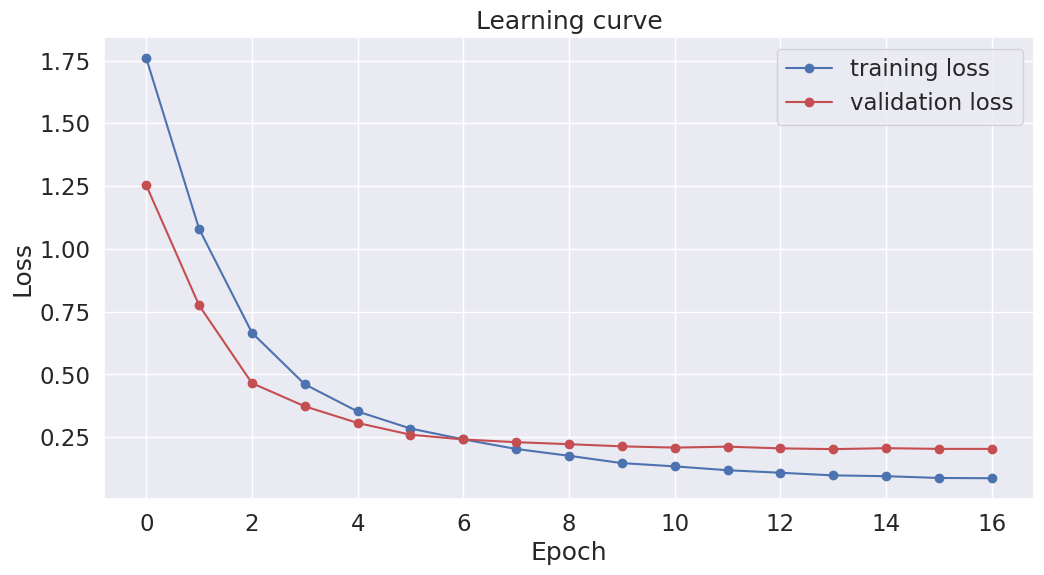

In [23]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [24]:
print(test_acc)

[1.2532493472099304, 0.7752275168895721, 0.465405598282814, 0.37317559123039246, 0.30692461133003235, 0.2600957304239273, 0.2411148026585579, 0.23036672174930573, 0.22235362231731415, 0.2137647047638893, 0.20870699733495712, 0.21250368654727936, 0.20566990971565247, 0.20269712060689926, 0.20642218738794327, 0.20368697494268417, 0.2035394087433815]


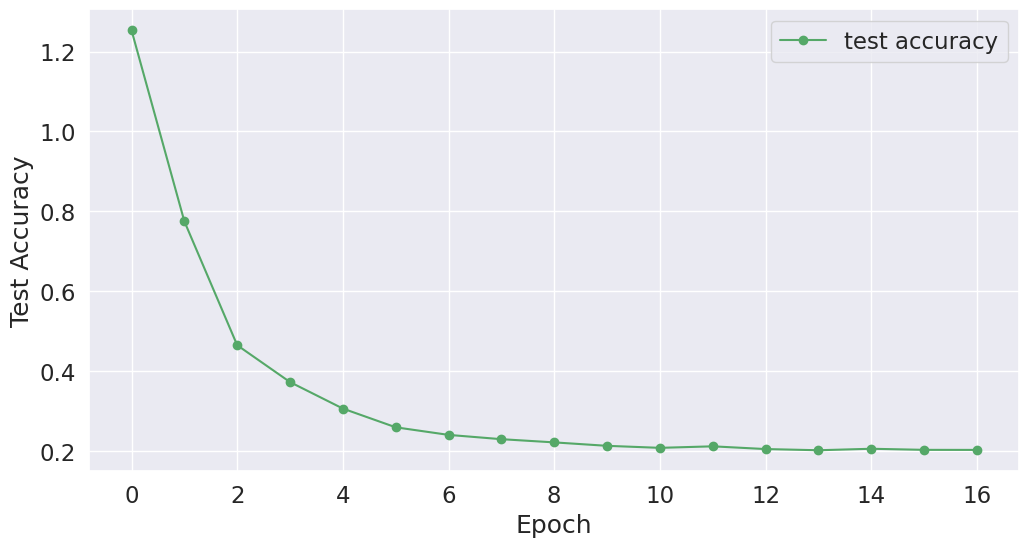

In [25]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(test_acc, 'g-o', label="test accuracy")


# Label the plot.
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()

plt.show()

In [26]:
q = 93
print(acc(False, q))
acc(True, q)


93 0.9113924050632911
0.565103933994848
___________________0___________________

Predict labels:  ['0', '0', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C', 'C-cont', 'C-cont',

___________________43___________________

Predict labels:  ['0', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', 'M', '0', '0', 'Q', 'Q-cont', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'M', '0']
Actual labels:  ['0', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', 'M', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'M', 'M', 'M', 'M-cont', '0', '0', '0', '0', 'M', '0', '0']


___________________44___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', 'M', '0', '0', '

___________________85___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', 'A', 'A-cont', '0', 'A-cont', 'A', '0', '0', '0', '0', 'A', 'A', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A', '0', '0', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', '0', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A-cont', 'A-cont', '0', 'A', 'A-cont', 'A-cont', 'A-cont', 'A-cont', '0', '0', '0', '0', 'A', 'A-cont', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A-cont', 'A-cont', '0', '0', 'C', 'C', 'C', 'C-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


___________________86___________________


___________________127___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'A', '0', '0', 'M', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'A', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'A', '0', '0', '0', '0', '0', 'C', 'C-cont', 'C-cont', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'A', 'A', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A-cont', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R-cont', '0

0.565103933994848

In [27]:
print(acc(False, 112))

93 0.9113924050632911
0.565103933994848


In [28]:
model = torch.load("test.ck")
model.eval()

print(acc(False))
print(acc(True))

FileNotFoundError: [Errno 2] No such file or directory: 'test.ck'